## PotatoDetection


In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/sharvarisoparkar/Desktop/MiniProject/potatoDataset",
    seed=10,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 5702 files belonging to 3 classes.


In [4]:

class_names =dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 1 0 2 1 0 0 1 1 2 2 1 2 0 1 1 0 1 2 1 1 2 0 2 2 1 0 1 0 0 0]


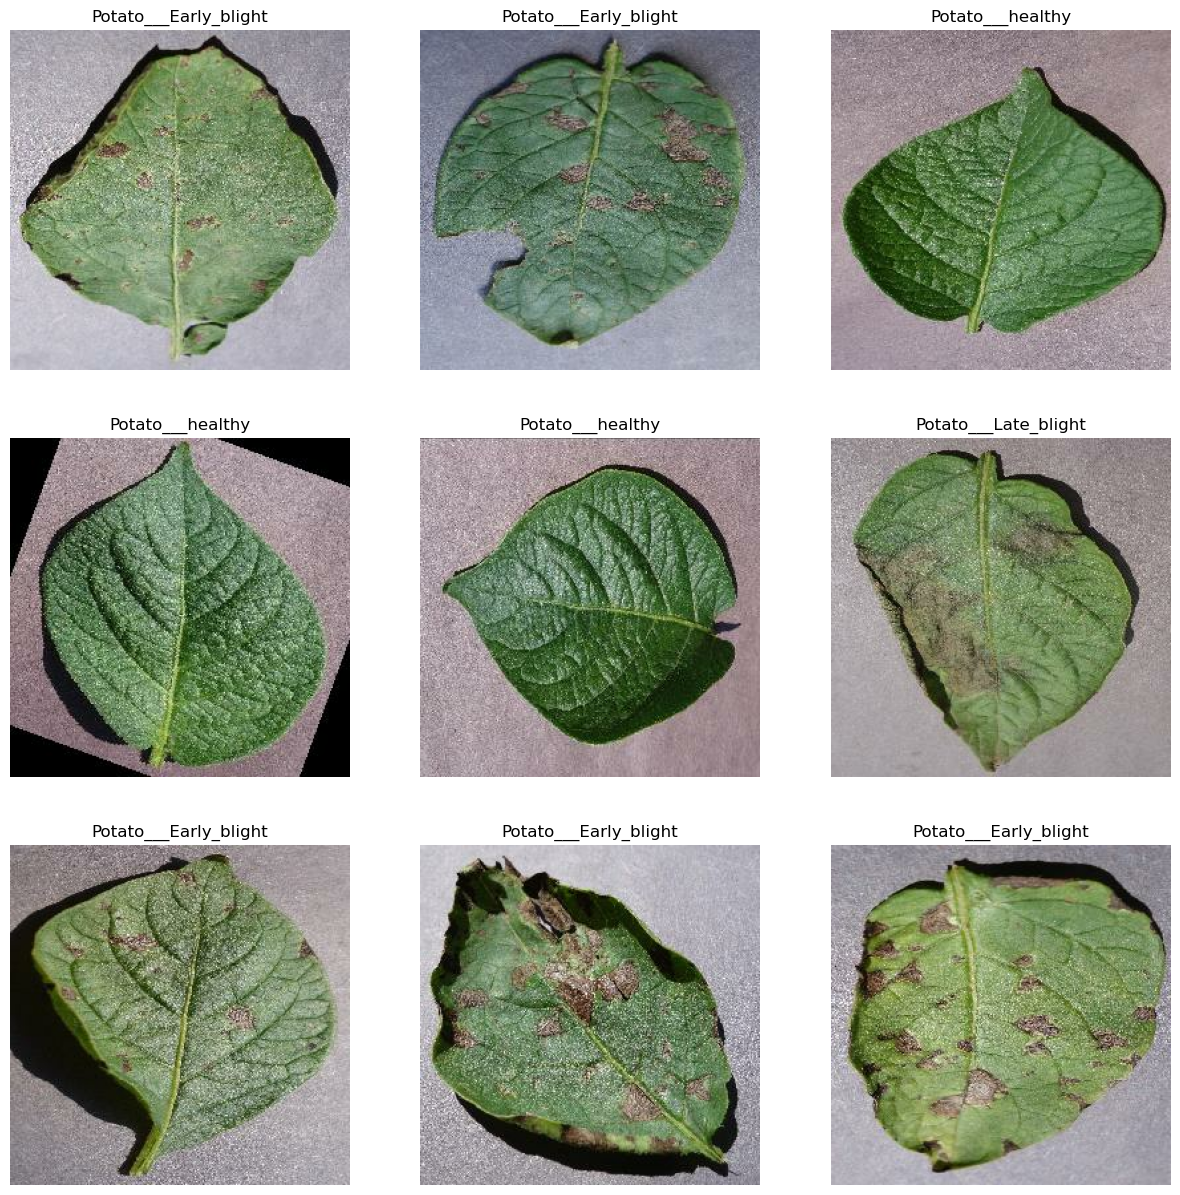

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

179

In [1]:
179*32

5728

In [8]:
train_size = 0.8
len(dataset)*train_size

143.20000000000002

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

125

In [11]:
val_size=0.1
len(dataset)*val_size

17.900000000000002

In [12]:

val_ds = test_ds.take(6)
len(val_ds)


6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

119

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds)

143

In [17]:
len(val_ds)

17

In [18]:
len(test_ds)

19

> Using TensorFlow's tf.data.Dataset API to create training, validation, and test datasets and applying caching, shuffling, and prefetching for better performance. This is a common practice when working with large datasets to optimize data loading during training.

Here's a breakdown of each step:

*  train_ds.cache(): Caching the dataset. This means that the elements of the dataset will be cached either in memory or on disk (depending on the available resources) after the first epoch. Subsequent epochs will use the cached data, reducing the time spent on data loading.

* train_ds.shuffle(1000): Shuffling the dataset. This randomizes the order of elements in the dataset, which is important during training to prevent the model from learning the order of the examples.

* train_ds.prefetch(buffer_size=tf.data.AUTOTUNE): Prefetching the dataset. This allows the data loading pipeline to asynchronously fetch batches of data in the background while the model is training on the current batch. tf.data.AUTOTUNE dynamically determines the optimal buffer size based on available system resources.

The same operations are applied to the val_ds (validation dataset) and test_ds (test dataset) to ensure consistency in preprocessing and to optimize their loading during training and evaluation.

This pipeline is a good practice for efficient and performant data input pipelines when working with machine learning models in TensorFlow.

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


tf.keras.layers.experimental.preprocessing.Resizing and tf.keras.layers.experimental.preprocessing.Rescaling layers to resize and rescale images in a preprocessing pipeline. This is a common practice when preparing image data for training neural networks.

Here's a breakdown of each layer:

    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE): This layer resizes the input images to the specified dimensions (in this case, IMAGE_SIZE x IMAGE_SIZE). Resizing is often necessary to ensure that all input images have the same dimensions before feeding them into a neural network.

    tf.keras.layers.experimental.preprocessing.Rescaling(1./255): This layer rescales the pixel values of the images. In this case, it scales the pixel values by dividing them by 255. This operation is common when working with image data because it brings the pixel values into the range [0, 1], making it easier for the neural network to learn.

In [20]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


Data augmentation is a technique commonly used in computer vision tasks to artificially increase the diversity of the training dataset by applying random transformations to the input data.

Here's a breakdown of each layer:

    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"): This layer randomly flips the input images horizontally and vertically. Horizontal and vertical flips are common augmentations to increase the variability of the training data.

    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2): This layer randomly rotates the input images by a specified factor. In this case, the rotation is by a maximum of 0.2 radians (about 11.5 degrees). Rotation is another augmentation that helps the model become more invariant to the orientation of objects in the images.



In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


##### convolutional neural network (CNN) using the Keras Sequential API for an image classification task.

* input_shape: Defines the input shape for the model, consisting of the batch size, image dimensions (width and height), and number of channels.

* n_classes: Specifies the number of classes for the classification task.

* resize_and_rescale: A Sequential model that resizes and rescales the input images.

* layers.Conv2D: Convolutional layer with 32 filters, a kernel size of (3, 3), ReLU activation, and input shape specified.

* layers.MaxPooling2D: MaxPooling layer with a pool size of (2, 2).

* The architecture repeats Conv2D and MaxPooling2D layers to extract features from the input images.

* layers.Flatten(): Flattens the output to prepare for fully connected layers.

* layers.Dense: Dense (fully connected) layers with ReLU activation for feature processing and a softmax activation for the output layer.

* The model.build(input_shape=input_shape) line builds the model with the specified input shape.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
# 6 conv2d 
# 6 maxPooling layer 
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #low-level features such as edges, corners, and textures
    layers.MaxPooling2D((2, 2)),#The MaxPooling2D layer reduces spatial dimensions.
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),#Increasing Depth:
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #raw model output into probabilities for each class, and the class with the highest probability is predicted as the final output.
])

model.build(input_shape=input_shape)


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

    Optimizer: 'adam' - Adam is an optimization algorithm that is widely used for training neural networks. It adapts the learning rates of each parameter during training.

    Loss Function: tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) - This is the loss function used for training the model. It is suitable for multi-class classification problems. Setting from_logits to False indicates that the model produces probability scores for each class (softmax activation).

    Metrics: ['accuracy'] - During training, the model's performance is monitored using accuracy, which is a common metric for classification tasks. It represents the ratio of correctly predicted instances to the total instances.

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)



Epoch 1/5
143/143 [==============================] - 358s 2s/step - loss: 0.7847 - accuracy: 0.6149 - val_loss: 0.7444 - val_accuracy: 0.7335
Epoch 2/5
143/143 [==============================] - 462s 3s/step - loss: 0.3408 - accuracy: 0.8711 - val_loss: 0.3883 - val_accuracy: 0.8456
Epoch 3/5
143/143 [==============================] - 526s 4s/step - loss: 0.1823 - accuracy: 0.9307 - val_loss: 0.4435 - val_accuracy: 0.9062
Epoch 4/5
143/143 [==============================] - 366s 3s/step - loss: 0.1191 - accuracy: 0.9552 - val_loss: 0.2599 - val_accuracy: 0.9026
Epoch 5/5
143/143 [==============================] - 437s 3s/step - loss: 0.0694 - accuracy: 0.9766 - val_loss: 0.2926 - val_accuracy: 0.9007


In [28]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 13s 474ms/step - loss: 0.2707 - accuracy: 0.9038


In [29]:
scores

[0.27065590023994446, 0.9037800431251526]

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 909ms/step
predicted label: Potato___healthy


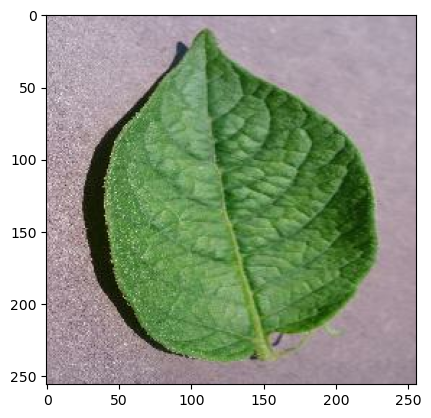

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


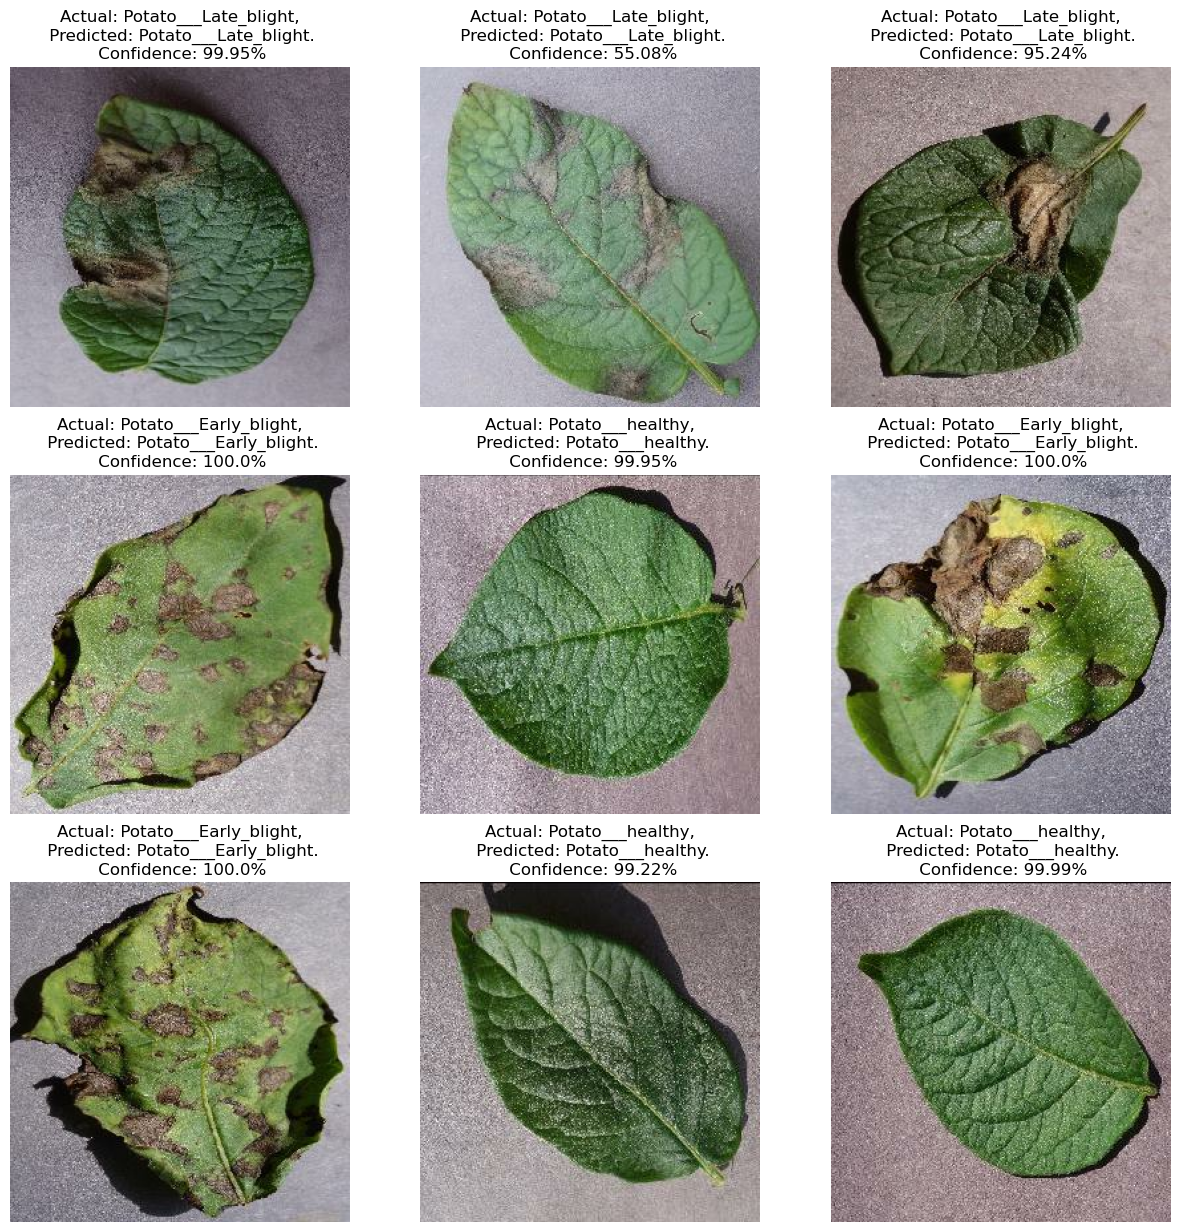

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
model_version=1
model.save(f'/Users/sharvarisoparkar/Desktop/MiniProject/Models/{model_version}')

INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/1/assets


INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/1/assets
